# Reinforcement Learning applied to an Atari Pong game

By Dennis Jensen s155629 & Stefan Carius Larsen s164029

This notebook displays and shows results of the implemented Deep Q-Networks applied to the atari game pong.
Throughout the project three different models were applied and trained on the pong game. Each model implements a neural network which consists of a convolutional network with three layers and two dense layers. 

With opengym.ai an atari pong game setup is supplied with a reward system. With the gym module you have an agent playing against a standard computer playing. The agent gets rewarded if it wins a round and gets penalized if it looses a round. One win gives +1 and a lost gives -1. 

<img src="pong_rgb.png">

## Scaling image, Grayscale image and Skipping Frames
For scaling, grayscaling and skipping frames the OpenAi Gym Wrappers are used.

### OpenAi Gym Wrappers


In [29]:
import gym
import collections
import numpy as np
import cv2

In [30]:
# Taken from OpenAI baseline wrappers
# https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        print(env.unwrapped.get_action_meanings())
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

## The architechture of the DQN, DDQN, CDDQN

Our Deep-Q-Network is made up of:

3 convolution layers
2 dense (fully connected) layers

In [31]:
import torch
from torch import nn
from torch import optim

In [32]:
class DQN(nn.Module):

    def __init__(self, input_shape, n_actions, learning_rate):
        super(DQN, self).__init__()

        channels = input_shape[0]

        # First conv layer
        conv_out_channels = 32  # <-- Filters in your convolutional layer
        kernel_size = 8  # <-- Kernel size
        conv_stride = 4  # <-- Stride
        conv_pad = 0  # <-- Padding

        # Second conv layer
        conv_out_channels_2 = 64  # <-- Filters in your convolutional layer
        kernel_size_2 = 4  # <-- Kernel size
        conv_stride_2 = 2  # <-- Stride
        conv_pad_2 = 0  # <-- Padding

        # Third conv layer
        conv_out_channels_3 = 64  # <-- Filters in your convolutional layer
        kernel_size_3 = 3  # <-- Kernel size
        conv_stride_3 = 1  # <-- Stride
        conv_pad_3 = 0  # <-- Padding

        self.conv = nn.Sequential(
            nn.Conv2d(channels, conv_out_channels, kernel_size, conv_stride, conv_pad),
            nn.ReLU(),
            nn.Conv2d(conv_out_channels, conv_out_channels_2, kernel_size_2, conv_stride_2, conv_pad_2),
            nn.ReLU(),
            nn.Conv2d(conv_out_channels_3, conv_out_channels_3, kernel_size_3, conv_stride_3, conv_pad_3),
            nn.ReLU()
        )


        out_features = self.conv_out_features(input_shape)

        self.out = nn.Sequential(
            nn.Linear(out_features, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        return self.out(x)

    def conv_out_features(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))


    def calculate_loss(self, batch, net, target_net, GAMMA, model, device="cpu"):
        """
        This calculate loss function computes loss in three different ways depending on model chosen.
        DQN - One network computing next state and current state
        DDQN - Target network computing next state and training network computing current state
        CDDQN - Seperate networks computes both next state and current state and then loss is computed from the
        minimum of the two next states
        """
        states, actions, rewards, dones, next_states = batch

        states_v = torch.tensor(states).to(device)
        next_states_v = torch.tensor(next_states).to(device)
        actions_v = torch.tensor(actions).to(device)
        rewards_v = torch.tensor(rewards).to(device)
        done = torch.tensor(dones).to(device)

        if model == 'DQN' or model == 'DDQN':
            if model == 'DQN':
                state_action_values = net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)
                next_state_values = net(next_states_v).max(1)[0]
            elif model == 'DDQN':
                state_action_values = net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)
                next_state_values = target_net(next_states_v).max(1)[0]

            next_state_values[done] = 0.0
            next_state_values = next_state_values.detach()

            expected_state_action_values = next_state_values * GAMMA + rewards_v

            return nn.MSELoss()(state_action_values, expected_state_action_values)

        elif model == 'CDDQN':
            state_Q1 = net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)
            state_Q2 = target_net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)

            next_Q1 = net(next_states_v).max(1)[0]
            next_Q2 = target_net(next_states_v).max(1)[0]
            # print(next_Q2)
            next_Q = torch.min(
                next_Q1,
                next_Q2
            )

            # next_Q = next_Q.view(next_Q.size(0), 1)
            next_Q[done] = 0.0
            next_Q = next_Q.detach()

            expected_Q = rewards_v + GAMMA * next_Q
            # expected_Q = expected_Q.detach()

            loss_1 = nn.MSELoss()(state_Q1, expected_Q)
            loss_2 = nn.MSELoss()(state_Q2, expected_Q)

            return loss_1, loss_2

## Memory Class for Experience Replay

The memory is for being able to learn from uncorrelated data points.

In [33]:
Transition = collections.namedtuple('Transition', ('state', 'action', 'reward', 'done', 'new_state'))

class Memory():
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def save_to_memory(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])

        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.bool), np.array(next_states)

## Agent Class 

The agent class is for playing the game and saving the plays to the memory to learn from it later.

In [34]:
class Agent():
    def __init__(self, env, memory):
        self.env = env
        self.memory = memory
        self.env_state = None
        self.env_set = False

    def reset_environtment(self):
        self.env_state = self.env.reset()
        self.env_set = True
        self.total_reward = 0.0

    def random_epsilon_greedy(self, network, device):
        assert (self.env_set), "Please initialize game before playing by resetting or inputting a state"
        state = np.array([self.env_state], copy=False)
        state = torch.tensor(state).to(device)
        q_values = network(state)
        _, pref_action = torch.max(q_values, dim=1)
        action = int(pref_action.item())
        return action

    def play_action(self, network, e=0, device='cpu'):
        done_reward = None
        if np.random.random() < e:
            action = self.env.action_space.sample()
        else:
            action = self.random_epsilon_greedy(network, device)

        # Do action in the environment
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        old_state = self.env_state
        self.env_state = new_state

        self.memory.save_to_memory(old_state, action, reward, done, self.env_state)

        if done:
            done_reward = self.total_reward
            self.reset_environtment()

        return done_reward


## Training the models

Depending on the model, there is a different approach for updaing and training the model. All these are implemented in the following functions.




In [35]:
import time
import os
import re

In [36]:
# Some of the training loop has been inspired by https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0

def name_new(file, num=0):
    if os.path.exists(file) and num==0:
        return name_new(file + f'_{num+1}', num+1)
    else:
        if os.path.exists(file):
            # print("Here?")
            remove_str = re.findall(f'_\d+', file)[0]
            # print(remove_str)
            new_name = file.replace(remove_str, '') + f'_{num+1}'
            return name_new(new_name, num+1)
        else:
            # print(file)
            return file

def update(batch_size, memory, net, target_net, gamma, model, device):
    if model == 'DDQN' or model == 'DQN':
        net.optimizer.zero_grad()
        batch = memory.sample(batch_size)
        loss_t = net.calculate_loss(batch, net, target_net, gamma, model, device)
        loss_t.backward()
        net.optimizer.step()
    elif model == 'CDDQN':
        batch = memory.sample(batch_size)
        loss_1, loss_2 = net.calculate_loss(batch, net, target_net, gamma, model, device)

        net.optimizer.zero_grad()
        loss_1.backward()
        net.optimizer.step()

        target_net.optimizer.zero_grad()
        loss_2.backward()
        target_net.optimizer.step()



def train(env, net, target_net, epsilon_data, agent, memory, gamma, device,
          LEARNING_STARTS, TARGET_UPDATE_FREQ, batch_size, model):
    # main loop
    frame_num = 0
    prev_input = None

    # initialization of variables used in the main loop
    reward_sum = 0
    total_rewards = []
    start = time.time()
    timestep_frame = 0
    best_mean_reward = None
    mean_reward_bound = 20.5
    freq_saving_reward = 1000
    save_reward = False
    # print(os.getcwd())
    filename = './data/frames_reward'
    file_name = name_new(filename)
    # print(file_name)
    name_to_save = model

    while True:
        frame_num += 1
        epsilon = max(epsilon_data[0], epsilon_data[1] - frame_num / epsilon_data[2])

        reward = agent.play_action(net, epsilon, device)

        if frame_num & freq_saving_reward == 0:
            save_reward = True

        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_num - timestep_frame) / (time.time() - start)
            timestep_frame = frame_num
            start = time.time()
            mean_reward = np.mean(total_rewards[-100:])
            print("{} frames: done {} games, mean reward {}, eps {}, speed {} f/s".format(
                frame_num, len(total_rewards), round(mean_reward, 3), round(epsilon, 2), round(speed, 2)))

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), f'./data/{name_to_save}_10_6' + "-" + str(len(total_rewards)) + ".dat")
                if best_mean_reward is not None:
                    print("New best mean reward {} -> {}, model saved".format(round(best_mean_reward, 3),
                                                                              round(mean_reward, 3)))
                best_mean_reward = mean_reward

            if mean_reward > mean_reward_bound and len(total_rewards) > 10:
                print("Game solved in {} frames! Average score of {}".format(frame_num, mean_reward))
                break

            if save_reward:
                with open(file_name, 'a') as file:
                    file.write(f'{frame_num}:{round(mean_reward, 2)}:{round(epsilon, 2)}\n')

                save_reward = False

        if len(memory.buffer) < LEARNING_STARTS:
            continue

        if frame_num % TARGET_UPDATE_FREQ == 0 and model == 'DDQN':
            target_net.load_state_dict(net.state_dict())

        # Update depending on model
        update(batch_size, memory, net, target_net, gamma, model, device)

    env.close()

## Learning Parameters & Other Parameters

In [37]:
# Epsilon greedy parameters
EPSILON_DECAY = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02
epsilon_data = [EPSILON_FINAL, EPSILON_START, EPSILON_DECAY]


# Hyperparameters
learning_rate = 1e-4
REPLAY_SIZE = 100000
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 1000
DELAY_LEARNING = 50000
GAMMA = 0.99

## Initiating training, random play or playing pretrained model

In [38]:
UP_ACTION = 2
DOWN_ACTION = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This options dict was created from sys.argv[x] normally, but in ipynb this is redundant, hence a dictionary is made here.
option_dict = {'random': False, 'train': False, 'oldnetwork': False} # Change dictionary values for decision making.
model = 'DDQN' # Either DQN, DDQN or CDDQN

# Environment and neural networks
env = make_env('PongNoFrameskip-v4')
net = DQN(env.observation_space.shape, env.action_space.n, learning_rate).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n, learning_rate).to(device)

# Agent and memory handling
memory = Memory(REPLAY_SIZE)
agent = Agent(env, memory)

initial_observation = env.reset()



if 'cuda' in str(device):
    print('The GPU is being used')
else:
    print('The CPU is being used')

if option_dict['random']:
    play_random(env, UP_ACTION, DOWN_ACTION, seconds=5)

if option_dict['train']:
    print("Training")
    print("ReplayMemory will require {}gb of GPU RAM".format(round(REPLAY_SIZE * 32 * 84 * 84 / 1e+9, 2)))
    agent.reset_environtment()
    train(env, net, target_net, epsilon_data, agent, memory, GAMMA, device,
                DELAY_LEARNING, TARGET_UPDATE_FREQ, BATCH_SIZE, model)

if option_dict['oldnetwork']:
    file_path = './pull/Best_performing_model/DDQN_10_6-reward_7.97.dat'
    seconds = 30
    test_old_network(env, net, file_path, seconds, device)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
The GPU is being used


## After all three models have been trained displaying results is:


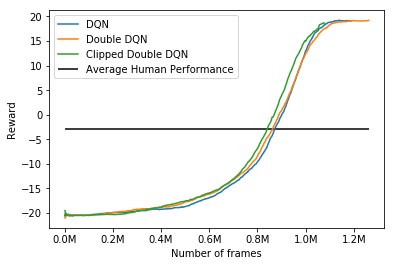

In [39]:
import re
import matplotlib.pyplot as plt
from matplotlib import ticker


def get_data(filename):
    x = []
    y = []
    e = []
    file = open(filename, 'r+')
    data = file.read()
    file.close()
    lines = data.split('\n')

    for line in lines:
        data_point = re.findall('(-?[\d.]+)', line)
        # print(data_point)
        if len(data_point) > 2:
            x_result, y_result, e_result = data_point[0], data_point[1], data_point[2]
            x.append(x_result)
            y.append(y_result)
            e.append(e_result)
        elif len(data_point) > 1:
            x_result, y_result = data_point[0], data_point[1]
            x.append(x_result)
            y.append(y_result)

    x = np.array(x).astype(np.float)
    y = np.array(y).astype(np.float)
    e = np.array(e).astype(np.float)
    return x, y, e

def plot_one():
    path = './../pull/data/frames_reward_8'
    # path = './../data/frames_reward.dat'
    frame, reward, e = get_data(path)
    frame = frame[1:]
    # print(max(reward))
    reward = reward[1:]
    e = e[1:]
    plt.figure()
    plt.plot(frame, reward)
    plt.ylabel('Reward')
    plt.xlabel('Number of frames')
    if len(e) > 1:
        plt.figure()
        plt.plot(frame, e)
        plt.xlabel('Number of frames')
        plt.ylabel('Epsilon')

    plt.show()

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def plot_epsilon():
    DDQN_path = './pull/Best_performing_model/DDQN/DDQN_frames_reward'

    x, y, e = get_data(DDQN_path)
    fig, ax = plt.subplots()

    e = e[:200]
    x = x[:200]
    plt.plot(x, e)
    plt.xlabel('Number of frames')
    plt.ylabel('Epsilon value')
    # formatter = ticker.FuncFormatter(millions)
    # ax.xaxis.set_major_formatter(formatter)

    plt.show()

def plot_multiple():
    """"""
    DDQN_path = './pull/pong_v4_data/DQN_reward'
    DQN_path = './pull/pong_v4_data/DDQN_reward'
    CDQN_path = './pull/pong_v4_data/CDDQN_reward'
    
    paths = [DQN_path, DDQN_path, CDQN_path]
    
    i = 0
    max_frame = 0
    min_frame = 0
    for file in paths:
        frame, reward, e = get_data(file)
        frame = frame[1:]
        reward = reward[1:]
        if max(frame) > max_frame:
            max_frame = max(frame)
        if min(frame) < min_frame:
            min_frame = min(frame)

        #print(max_frame/len(frame))

        #print(f'{max(reward)}')

        if i == 0:
            fig, ax = plt.subplots()
        x = []
        # frame = millions(frame)
        plt.plot(frame, reward)
        plt.ylabel('Reward')
        plt.xlabel('Number of frames')
        i += 1

    plt.hlines(-3, min_frame, max_frame)
    formatter = ticker.FuncFormatter(millions)

    plt.legend(['DQN', 'Double DQN', 'Clipped Double DQN', 'Average Human Performance'])
    ax.xaxis.set_major_formatter(formatter)

    plt.show()

if __name__ == '__main__':
    plot_multiple()